
# Rice Leaf Disease Classification — Ready-to-Run Notebook
**Purpose:** End-to-end local Jupyter notebook for EDA, training a CNN, augmentation experiments, and model comparison — prepared for GitHub upload.

**Files used (from your upload):**
- Dataset ZIP: `/mnt/data/riceleafdataset.zip`
- Project brief: `/mnt/data/PRCP-1001-RiceLeaf.docx`  
(These local paths are already present in this environment.)

**Instructions:**  
1. Run all cells sequentially.  
2. If you want to train faster, reduce `EPOCHS` or use a GPU runtime.  
3. Transfer-learning section will try to load ImageNet weights; if internet is unavailable it falls back to training without pretrained weights (the code handles that gracefully).


In [1]:

# 1) Imports and unzip dataset
import os
import zipfile
from pathlib import Path

DATA_ZIP = "/mnt/data/riceleafdataset.zip"   # <--- dataset zip uploaded by you
EXTRACT_TO = "/mnt/data/riceleafdataset"

os.makedirs(EXTRACT_TO, exist_ok=True)

if os.path.exists(DATA_ZIP):
    with zipfile.ZipFile(DATA_ZIP, 'r') as z:
        z.extractall(EXTRACT_TO)
    print("Extracted to:", EXTRACT_TO)
else:
    print("Dataset zip not found at:", DATA_ZIP)

# show folder structure (first two levels)
for root, dirs, files in os.walk(EXTRACT_TO):
    level = root.replace(EXTRACT_TO, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{Path(root).name}/")
    if level < 2:
        for f in files[:5]:
            print(f"{indent}  - {f}")


Dataset zip not found at: /mnt/data/riceleafdataset.zip
riceleafdataset/


Image folder: C:\Users\HP\OneDrive\Desktop\rice leaf project\riceleafdataset
Class counts:
 - Bacterial Leaf Blight: 220
 - Brownspot: 220
 - Leafsmut: 220


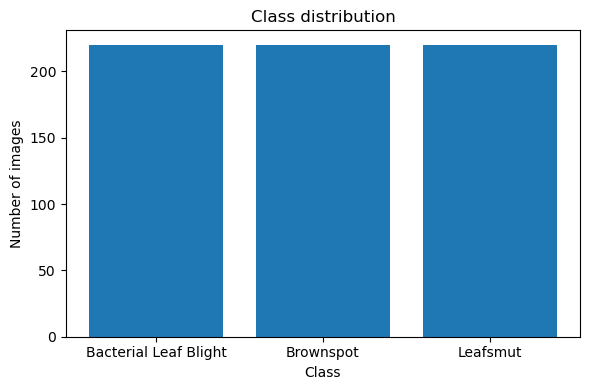

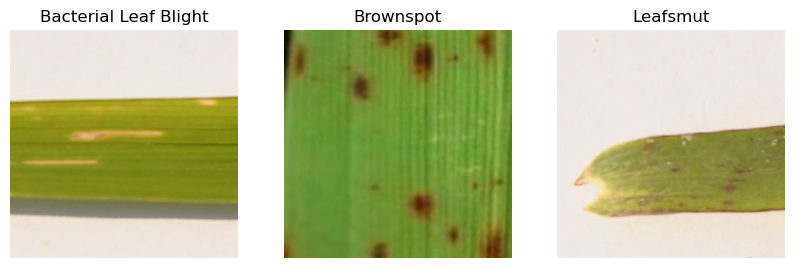

Image size stats (w x h):
 - min: [256 256]
 - max: [256 256]
 - median: [256. 256.]


In [3]:

# 2) Basic EDA - class counts, sample images, image sizes
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

# Try to detect image folder inside the extracted directory
def find_image_folder(base):
    for root, dirs, files in os.walk(base):
        imgs = [f for f in files if f.lower().endswith(('.jpg','.jpeg','.png'))]
        if imgs:
            return root
    return None

IMG_FOLDER = r"C:\Users\HP\OneDrive\Desktop\rice leaf project\riceleafdataset"
print("Image folder:", IMG_FOLDER)

from collections import defaultdict
class_counts = defaultdict(int)
samples = defaultdict(list)
if IMG_FOLDER:
    for root, dirs, files in os.walk(IMG_FOLDER):
        for f in files:
            if f.lower().endswith(('.jpg','.jpeg','.png')):
                cls = Path(root).name
                class_counts[cls] += 1
                if len(samples[cls]) < 5:
                    samples[cls].append(os.path.join(root,f))

print("Class counts:")
for k,v in class_counts.items():
    print(f" - {k}: {v}")

# class distribution plot
plt.figure(figsize=(6,4))
plt.bar(list(class_counts.keys()), list(class_counts.values()))
plt.title("Class distribution")
plt.ylabel("Number of images")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

# sample images
plt.figure(figsize=(10,4))
i = 1
for cls, imgs in samples.items():
    if imgs:
        img = Image.open(imgs[0])
        plt.subplot(1, len(samples), i)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
        i += 1
plt.show()

# image size stats
sizes = []
for root, dirs, files in os.walk(IMG_FOLDER):
    for f in files:
        if f.lower().endswith(('.jpg','.jpeg','.png')):
            try:
                w,h = Image.open(os.path.join(root,f)).size
                sizes.append((w,h))
            except:
                pass

if sizes:
    sizes_arr = np.array(sizes)
    print("Image size stats (w x h):")
    print(" - min:", sizes_arr.min(axis=0))
    print(" - max:", sizes_arr.max(axis=0))
    print(" - median:", np.median(sizes_arr, axis=0))
else:
    print("No image sizes found.")


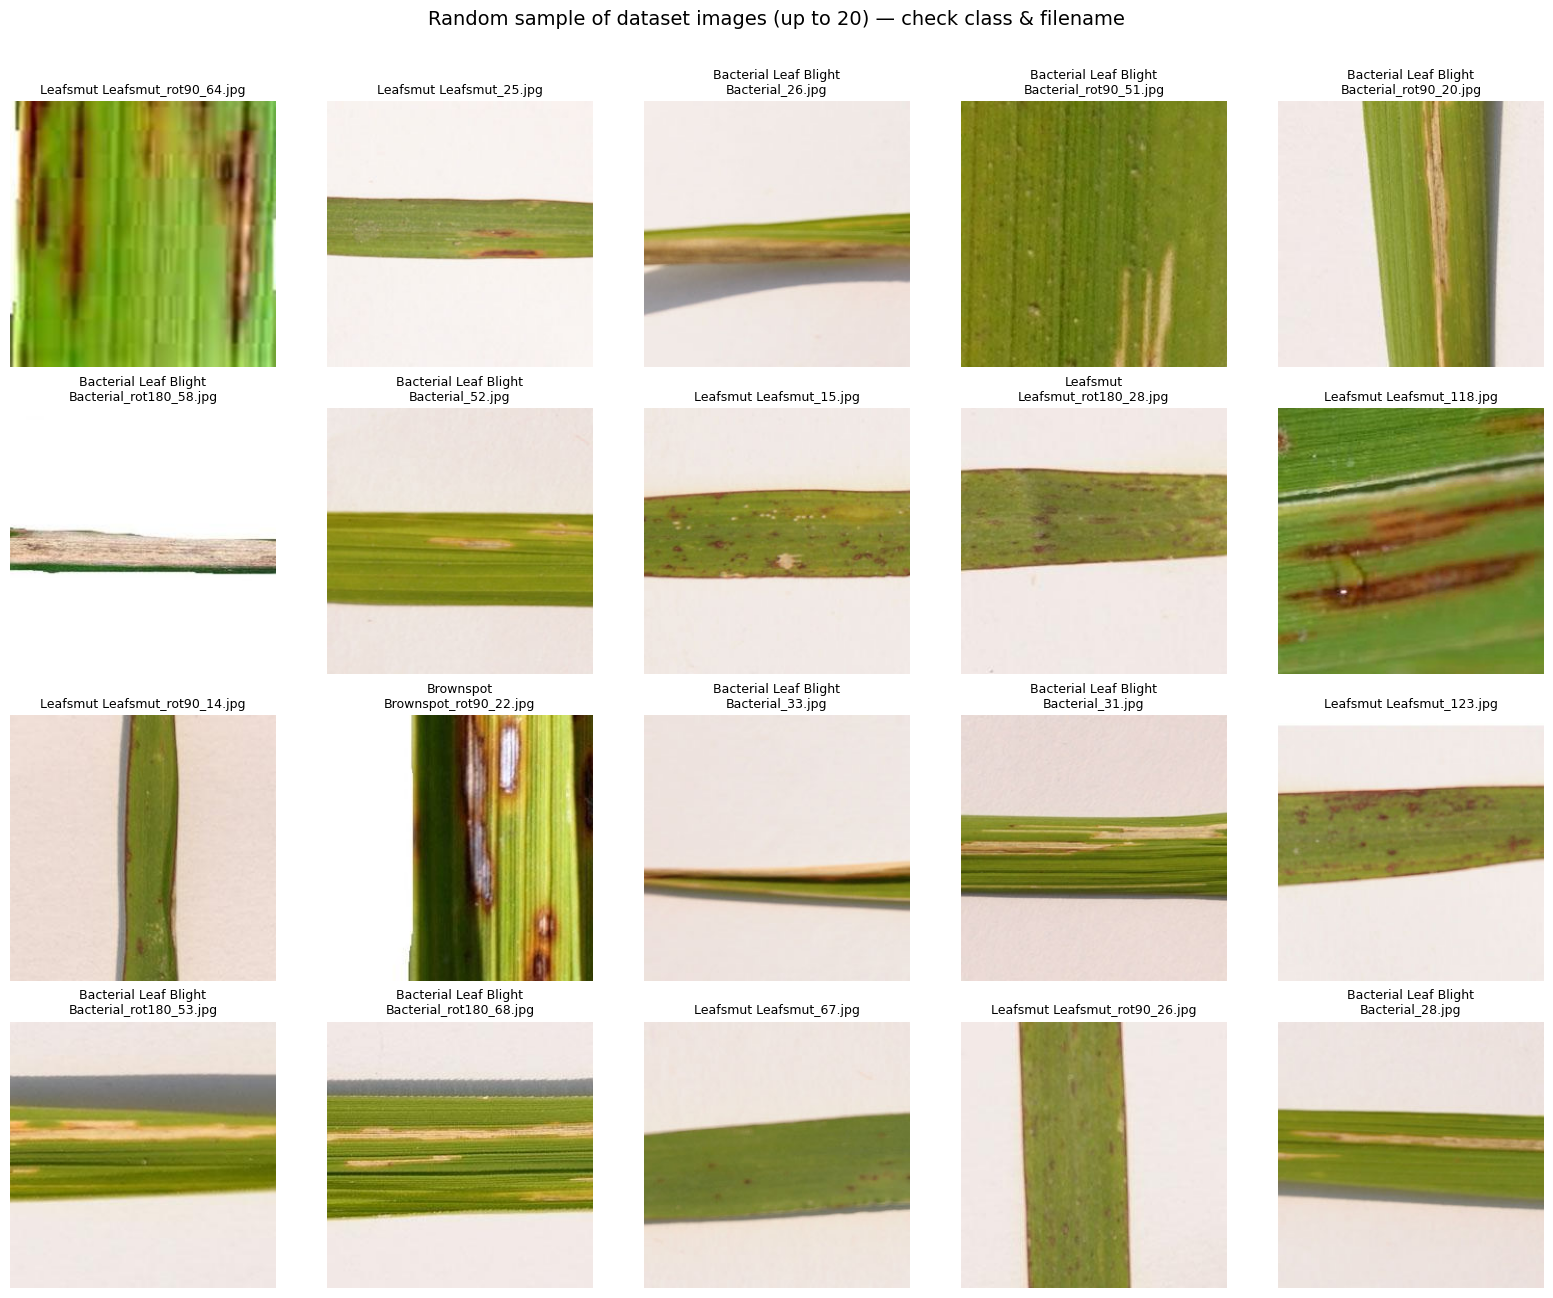

In [13]:
# --- Professional 20-image grid for EDA ---
import os, random
from PIL import Image
import matplotlib.pyplot as plt
import textwrap

# === SET THIS to your dataset folder ===
# Option A: relative path if notebook + dataset are same folder
# IMG_FOLDER = "riceleafdataset"

# Option B: absolute Windows example (your path)
# IMG_FOLDER = r"C:\Users\HP\OneDrive\Desktop\rice leaf project\riceleafdataset"

# Option C: notebook environment (server)
# IMG_FOLDER = "/mnt/data/riceleafdataset"

# Pick the correct one for your system:
IMG_FOLDER = r"C:\Users\HP\OneDrive\Desktop\rice leaf project\riceleafdataset"  # <<-- edit if needed

# === gather all image file paths ===
all_imgs = []
for root, dirs, files in os.walk(IMG_FOLDER):
    for f in files:
        if f.lower().endswith(('.jpg','.jpeg','.png')):
            all_imgs.append(os.path.join(root, f))

if len(all_imgs) == 0:
    raise FileNotFoundError(f"No images found under {IMG_FOLDER}. Check path and folder structure.")

# === sample images reproducibly ===
random.seed(42)
n_show = min(20, len(all_imgs))
sampled = random.sample(all_imgs, n_show)

# === helper to extract class label from path ===
def class_from_path(p):
    # assumes folder structure: .../<class_name>/<imagefile>
    return os.path.basename(os.path.dirname(p))

# === plot grid (4x5) ===
cols = 5
rows = (n_show + cols - 1) // cols
plt.figure(figsize=(16, 3.3 * rows))   # tall enough for labels

for i, img_path in enumerate(sampled, 1):
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print("Could not open:", img_path, "->", e)
        continue

    ax = plt.subplot(rows, cols, i)
    ax.imshow(img)
    ax.axis('off')

    # Title: class name
    cls = class_from_path(img_path)
    # Subtitle: shortened filename (wrap if long)
    fname = os.path.basename(img_path)
    fname_short = (fname if len(fname) <= 30 else "..." + fname[-27:])
    title = f"{cls}\n{fname_short}"
    # use smaller font and wrap
    ax.set_title("\n".join(textwrap.wrap(title, 30)), fontsize=9)

plt.suptitle("Random sample of dataset images (up to 20) — check class & filename", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [4]:

# 3) Prepare Keras ImageDataGenerators (train/val split) and utility functions
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

IMG_SIZE = (224,224)
BATCH_SIZE = 8
RANDOM_SEED = 42

# build file list and labels
filepaths = []
labels = []
for root, dirs, files in os.walk(IMG_FOLDER):
    for f in files:
        if f.lower().endswith(('.jpg','.jpeg','.png')):
            filepaths.append(os.path.join(root,f))
            labels.append(Path(root).name)

print("Total images found:", len(filepaths))

train_paths, val_paths, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels, random_state=RANDOM_SEED
)

train_datagen = ImageDataGenerator(rescale=1./255)
train_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.15,
    brightness_range=(0.7,1.3),
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

def paths_to_generator(paths, labels, datagen, shuffle=True):
    import pandas as pd
    df = pd.DataFrame({"filename": paths, "class": labels})
    gen = datagen.flow_from_dataframe(
        df,
        x_col="filename",
        y_col="class",
        target_size=IMG_SIZE,
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )
    return gen

train_gen = paths_to_generator(train_paths, train_labels, train_datagen)
train_aug_gen = paths_to_generator(train_paths, train_labels, train_aug_datagen)
val_gen = paths_to_generator(val_paths, val_labels, val_datagen, shuffle=False)


Total images found: 660
Found 528 validated image filenames belonging to 3 classes.
Found 528 validated image filenames belonging to 3 classes.
Found 132 validated image filenames belonging to 3 classes.


In [6]:

# 4) Define a simple CNN model (baseline)
from tensorflow.keras import layers, models

def build_simple_cnn(input_shape=IMG_SIZE + (3,), num_classes=None):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

if hasattr(train_gen, "num_classes"):
    num_classes = train_gen.num_classes
else:
    num_classes = len(train_gen.class_indices)

print("Detected classes (class_indices):", train_gen.class_indices)
print("num_classes =", num_classes)
model_baseline = build_simple_cnn(num_classes=num_classes)
model_baseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_baseline.summary()


Detected classes (class_indices): {'Bacterial Leaf Blight': 0, 'Brownspot': 1, 'Leafsmut': 2}
num_classes = 3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8


C:\Users\HP\anaconda3\envs\datascience_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.4702 - loss: 1.3079 - val_accuracy: 0.8485 - val_loss: 0.5759
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.7597 - loss: 0.6426 - val_accuracy: 0.8182 - val_loss: 0.5043
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.8132 - loss: 0.5673 - val_accuracy: 0.8409 - val_loss: 0.4334
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.8699 - loss: 0.4283 - val_accuracy: 0.8333 - val_loss: 0.3933
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8799 - loss: 0.3530 - val_accuracy: 0.8864 - val_loss: 0.2798
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.9131 - loss: 0.2721 - val_accuracy: 0.9470 - val_loss: 0.2263
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.9136 - loss: 0.2865 - val_accuracy: 0.8864 - val_loss: 0.3358
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.8579 - loss: 0.4398 - val_accuracy: 0.8712 - val

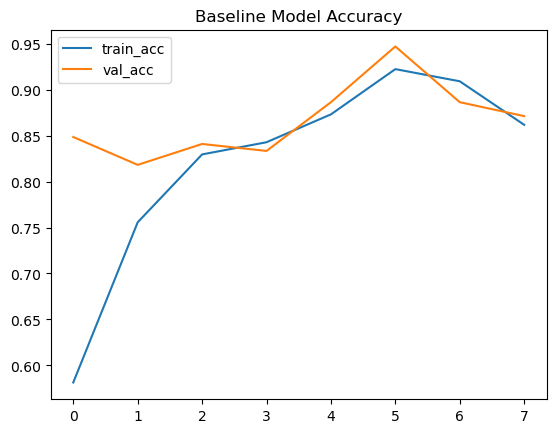

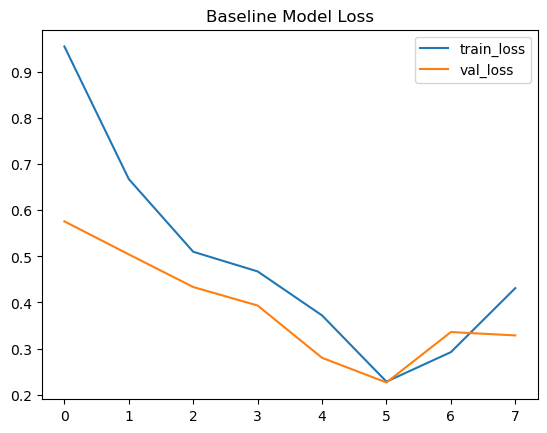

In [7]:

# 5) Train baseline model (small epochs for quick testing)
EPOCHS = 8
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]
history_baseline = model_baseline.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)
# plot accuracy and loss
plt.figure()
plt.plot(history_baseline.history['accuracy'], label='train_acc')
plt.plot(history_baseline.history['val_accuracy'], label='val_acc')
plt.title('Baseline Model Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_baseline.history['loss'], label='train_loss')
plt.plot(history_baseline.history['val_loss'], label='val_loss')
plt.title('Baseline Model Loss')
plt.legend()
plt.show()


Epoch 1/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.4821 - loss: 1.5607 - val_accuracy: 0.8030 - val_loss: 0.5715
Epoch 2/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - accuracy: 0.7665 - loss: 0.6906 - val_accuracy: 0.8182 - val_loss: 0.4546
Epoch 3/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - accuracy: 0.7650 - loss: 0.6137 - val_accuracy: 0.8788 - val_loss: 0.4072
Epoch 4/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 224ms/step - accuracy: 0.7468 - loss: 0.6424 - val_accuracy: 0.8636 - val_loss: 0.4036
Epoch 5/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - accuracy: 0.7920 - loss: 0.5355 - val_accuracy: 0.7348 - val_loss: 0.5851
Epoch 6/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 226ms/step - accuracy: 0.7778 - loss: 0.5821 - val_accuracy: 0.8561 - val_loss: 0.4125
Epoch 7/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.8601 - loss: 0.4689 - val_accuracy: 0.8561 - val_loss: 0.4081


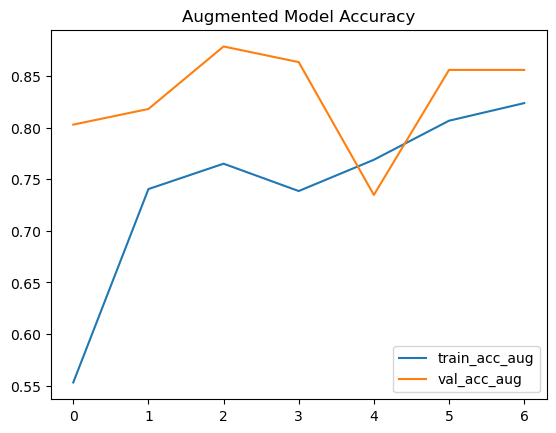

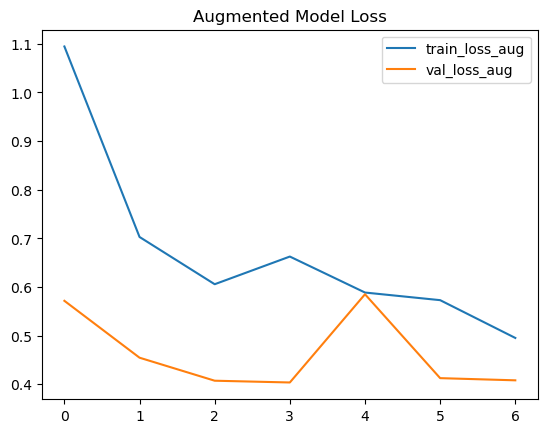

In [8]:

# 6) Train model with data augmentation (same architecture)
model_aug = build_simple_cnn(num_classes=num_classes)
model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 12
history_aug = model_aug.fit(
    train_aug_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

plt.figure()
plt.plot(history_aug.history['accuracy'], label='train_acc_aug')
plt.plot(history_aug.history['val_accuracy'], label='val_acc_aug')
plt.title('Augmented Model Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_aug.history['loss'], label='train_loss_aug')
plt.plot(history_aug.history['val_loss'], label='val_loss_aug')
plt.title('Augmented Model Loss')
plt.legend()
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step 
Confusion Matrix:
 [[35  2  7]
 [ 2 42  0]
 [ 4  3 37]]


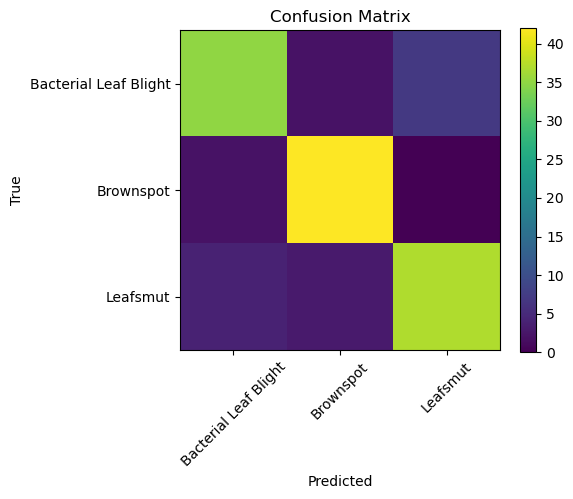


Classification Report:
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.85      0.80      0.82        44
            Brownspot       0.89      0.95      0.92        44
             Leafsmut       0.84      0.84      0.84        44

             accuracy                           0.86       132
            macro avg       0.86      0.86      0.86       132
         weighted avg       0.86      0.86      0.86       132



In [9]:

# 7) Confusion matrix + classification report for best model (choose augmented model for example)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

best_model = model_aug

val_steps = int(np.ceil(val_gen.samples / val_gen.batch_size))
preds = best_model.predict(val_gen, steps=val_steps)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(val_gen.class_indices)), list(val_gen.class_indices.keys()), rotation=45)
plt.yticks(range(len(val_gen.class_indices)), list(val_gen.class_indices.keys()))
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step 
Loaded MobileNetV2 with ImageNet weights.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 2,227,715 (8.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 489ms/step - accuracy: 0.5947 - loss: 1.0850 - val_accuracy: 0.3636 - val_loss: 7.5134
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 446ms/step - accuracy: 0.8242 - loss: 0.5351 - val_accuracy: 0.4470 - val_loss: 6.8240
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 459ms/step - accuracy: 0.8577 - loss: 0.3717 - val_accuracy: 0.4848 - val_loss: 4.2784
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 453ms/step - accuracy: 0.8530 - loss: 0.4329 - val_accuracy: 0.3485 - val_loss: 7.8381
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 447ms/step - accuracy: 0.8734 - loss: 0.3788 - val_accuracy: 0.7500 - val_loss: 1.5008
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 444ms/step - accuracy: 0.8193 - loss: 0.4181 - val_accuracy: 0.8561 - val_loss: 0.4852
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 448ms/step - accuracy: 0.8914 - loss: 0.3227 - val_accuracy: 0.3712 - val_loss: 8.5726
Epoch 8/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 449ms/step - accuracy: 0.9261 - loss: 0.2319 - val_accuracy: 0.

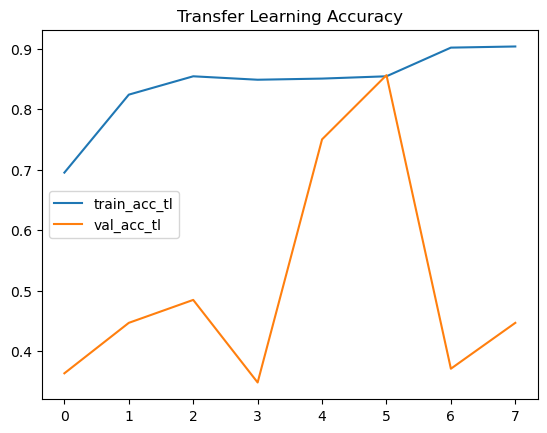

In [10]:

# 8) Transfer Learning (MobileNetV2) - try to use pretrained weights; fallback if not available
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

def build_mobilenetv2(num_classes, input_shape=IMG_SIZE+(3,), weights='imagenet'):
    base = MobileNetV2(include_top=False, input_shape=input_shape, weights=weights)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=outputs)
    return model

try:
    model_tl = build_mobilenetv2(num_classes=num_classes, weights='imagenet')
    print('Loaded MobileNetV2 with ImageNet weights.')
except Exception as e:
    print('Could not load pretrained weights (likely offline). Falling back to uninitialized MobileNetV2. Error:', e)
    model_tl = build_mobilenetv2(num_classes=num_classes, weights=None)

model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_tl.summary()

EPOCHS = 8
history_tl = model_tl.fit(
    train_aug_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

plt.figure()
plt.plot(history_tl.history['accuracy'], label='train_acc_tl')
plt.plot(history_tl.history['val_accuracy'], label='val_acc_tl')
plt.title('Transfer Learning Accuracy')
plt.legend()
plt.show()


In [11]:
# 9) Save best model
MODEL_OUT = "rice_leaf_best_model.h5"
best_model.save(MODEL_OUT)
print("Model saved:", MODEL_OUT)

# IMPORTANT — use train_gen.class_indices for consistent mapping
import json
labels_map = {v: k for k, v in sorted(train_gen.class_indices.items(), key=lambda x: x[1])}

with open("label_map.json", "w") as f:
    json.dump(labels_map, f)

print("Saved label map:", labels_map)

# Also store class_names for classification report order
class_names = [labels_map[i] for i in range(len(labels_map))]
print("Class names:", class_names)



Model saved: rice_leaf_best_model.h5
Saved label map: {0: 'Bacterial Leaf Blight', 1: 'Brownspot', 2: 'Leafsmut'}
Class names: ['Bacterial Leaf Blight', 'Brownspot', 'Leafsmut']


In [12]:

# 10) Prediction helper: load model and predict on a new image
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

def predict_image(img_path, model_path=MODEL_OUT, label_map_path="/mnt/data/label_map.json"):
    model = load_model(model_path)
    import json
    with open(label_map_path, "r") as f:
        label_map = json.load(f)
    img = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
    arr = np.array(img)/255.0
    arr = np.expand_dims(arr, 0)
    preds = model.predict(arr)
    cls = np.argmax(preds, axis=1)[0]
    return label_map[str(cls)], float(np.max(preds))

# Example usage (uncomment and provide path):
# print(predict_image("/path/to/some_leaf.jpg"))



---

## Notes & Next Steps (for GitHub upload)
- Notebook saved as this single `.ipynb` file — suitable for local Jupyter and for pushing to GitHub.
- If you want to run faster, use a GPU runtime (Colab / local GPU). Reduce BATCH_SIZE or IMG_SIZE for quick tests.
- Transfer-learning with ImageNet weights needs internet. The code falls back if offline.
- I recommend adding a small `requirements.txt` when uploading to GitHub with pinned versions:
```
tensorflow
numpy
pandas
matplotlib
scikit-learn
Pillow
```
- If you want, I can also generate a ready `README.md` and `requirements.txt` and push all files into a ZIP for upload.
